In [1]:
import sys
import os
n_cores = len(os.sched_getaffinity(0))
n_cores = int(n_cores//2+1)
os.environ["OMP_NUM_THREADS"] = f"{n_cores}"
os.environ["OPENBLAS_NUM_THREADS"] = f"{n_cores}"
os.environ["MKL_NUM_THREADS"] = f"{n_cores}"
os.environ["VECLIB_MAXIMUM_THREADS"] = f"{n_cores}"
os.environ["NUMEXPR_NUM_THREADS"] = f"{n_cores}"
os.environ["NUMBA_CACHE_DIR"]='/tmp/numba_cache'

import numpy as np
import pandas as pd
import scipy as sp
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
import h5py    

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

import upsetplot
from upsetplot import UpSet
from upsetplot import from_indicators

from matplotlib_venn import venn2, venn3

path_result = 'results/LUHMES/'
os.makedirs(path_result, exist_ok=True)

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()

# Data

In [2]:
with h5py.File('data/LUHMES/LUHMES.h5', 'r') as f:
    print(f.keys())
    counts = np.array(f['counts'], dtype='float')
    sgRNA = np.array(f['sgRNA'], dtype='S32').astype(str)
    gene_names = np.array(f['gene_names'], dtype='S32').astype(str)
    var_features = pd.DataFrame(np.array(f['var.features']))
    var_features.index = gene_names
    cell_ids = np.array(f['cell_ids'], dtype='S32').astype(str)
    covariates = pd.DataFrame(np.array(f['covariates'])).astype(float).values # 'S.Score','G2M.Score','batch','pt_state'
    pt_state = covariates[:,-1]
    covariates = np.c_[np.log(np.sum(counts, axis=1)),  covariates[:,:-1]]    
    id_cell = (~np.char.startswith(sgRNA, 'RELN'))
    counts = counts[id_cell] 
    sgRNA = sgRNA[id_cell]
    cell_ids = cell_ids[id_cell]
    covariates = covariates[id_cell]
    pt_state = pt_state[id_cell]
    print(np.unique(covariates[:,-1:]))
    covariates = np.c_[
        pt_state,
        covariates[:,:-1],
        OneHotEncoder(drop='first', sparse_output=False).fit_transform(covariates[:,-1:])
    ]
    
gRNA_names = ['Nontargeting','ADNP', 'ARID1B', 'ASH1L', 'CHD2', 'CHD8', 'CTNND2', 'DYRK1A',
    'HDAC5', 'MECP2', 'MYT1L', 'POGZ', 'PTEN', 'SETD5']


perturbed = np.array([s.split('_')[0] for s in sgRNA])
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, categories=[gRNA_names])
perturbed_one_hot_encoded = one_hot_encoder.fit_transform(perturbed.reshape(-1, 1))
covariates = np.c_[covariates, perturbed_one_hot_encoded]

print(counts.shape, len(gRNA_names), cell_ids.shape, covariates.shape)
print(perturbed_one_hot_encoded.shape)

scaler = StandardScaler()
X = scaler.fit_transform(covariates)
Y = counts

n, p = Y.shape
d = X.shape[1]

print(X.shape, Y.shape)
C = np.sort(np.argsort(var_features['vst.variance.standardized'].values)[:4000])
CC = np.where(var_features['vst.variance.standardized'] > 1.)[0]
print(len(C), len(CC))

<KeysViewHDF5 ['cell_ids', 'counts', 'covariates', 'gene_names', 'sgRNA', 'var.features']>
[1. 2. 3.]
(8320, 13086) 14 (8320,) (8320, 19)
(8320, 13)
(8320, 19) (8320, 13086)
4000 4163


# Figure F4: Histogram of other perturbations

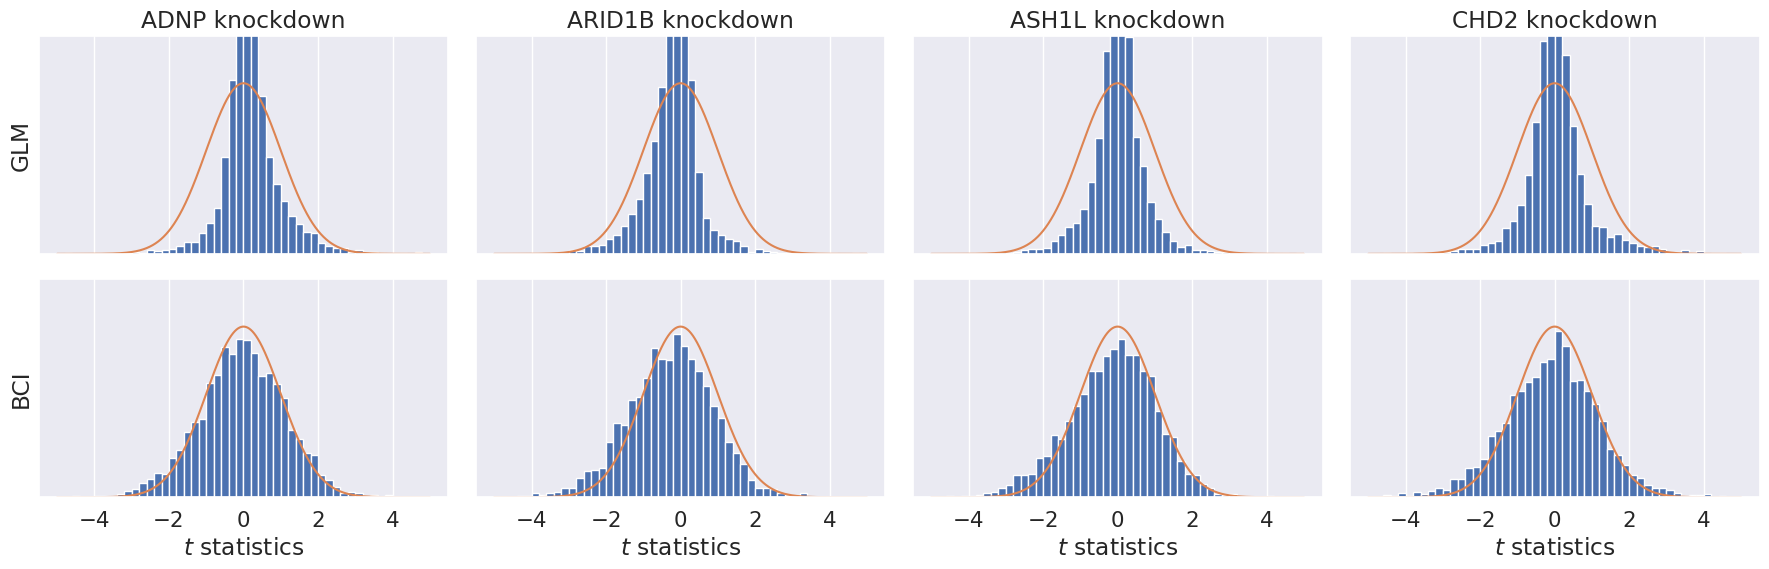

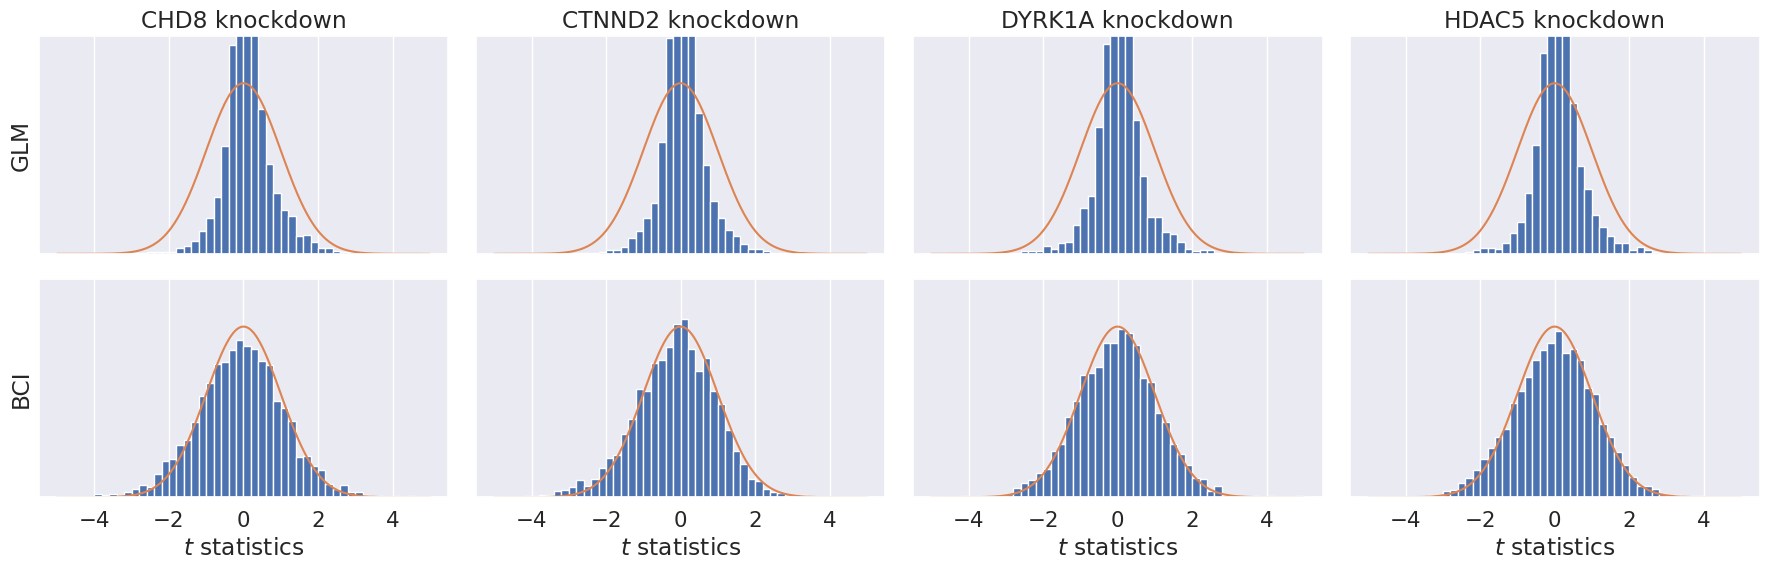

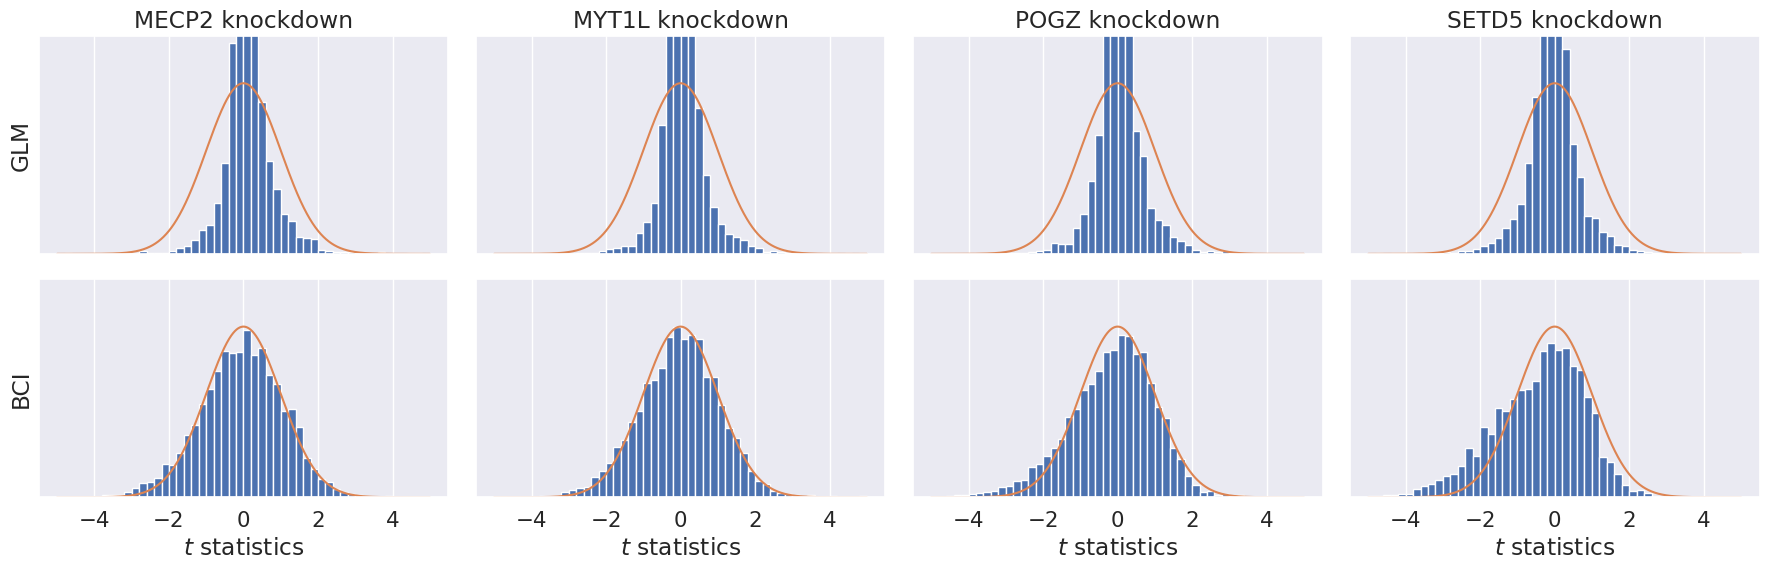

In [3]:
for ibatch_gRNA in range(3):

    sns.set(font_scale=1.4)
    fig, axes = plt.subplots(2,4, figsize=(18,6), sharex=True, sharey=True)

    xmax=5
    for j in range(4):
        ix = 1+j+ibatch_gRNA*4
        if ibatch_gRNA==2 and j==3:
            ix += 1
        
        axes[0,j].hist(tvals[ix,:], bins=50, range=(-xmax,xmax), density=True)
        axes[1,j].hist(t_values[ix,:], bins=50, range=(-xmax,xmax), density=True)
        
        x_axis = np.arange(-xmax, xmax, 0.001)       
        for i in range(2):
            axes[i,j].plot(x_axis, sp.stats.norm.pdf(x_axis,0,1))
            axes[i,j].set_ylim([0,0.51])
        axes[0,j].set_title('{} knockdown'.format(gRNA_names[ix]))
        
        if j>0:
            axes[i,j].set_yticks([])
        axes[1,j].set_xlabel('$t$ statistics')
    
    axes[0,0].set_ylabel('GLM')
    axes[1,0].set_ylabel('PII')

    fig.tight_layout()
    plt.plot()
    plt.savefig(path_result+'glm_stat_{}.pdf'.format(ibatch_gRNA), bbox_inches='tight', dpi=300)

# Figure 2: Histogram of PTEN perturbations (other methods)

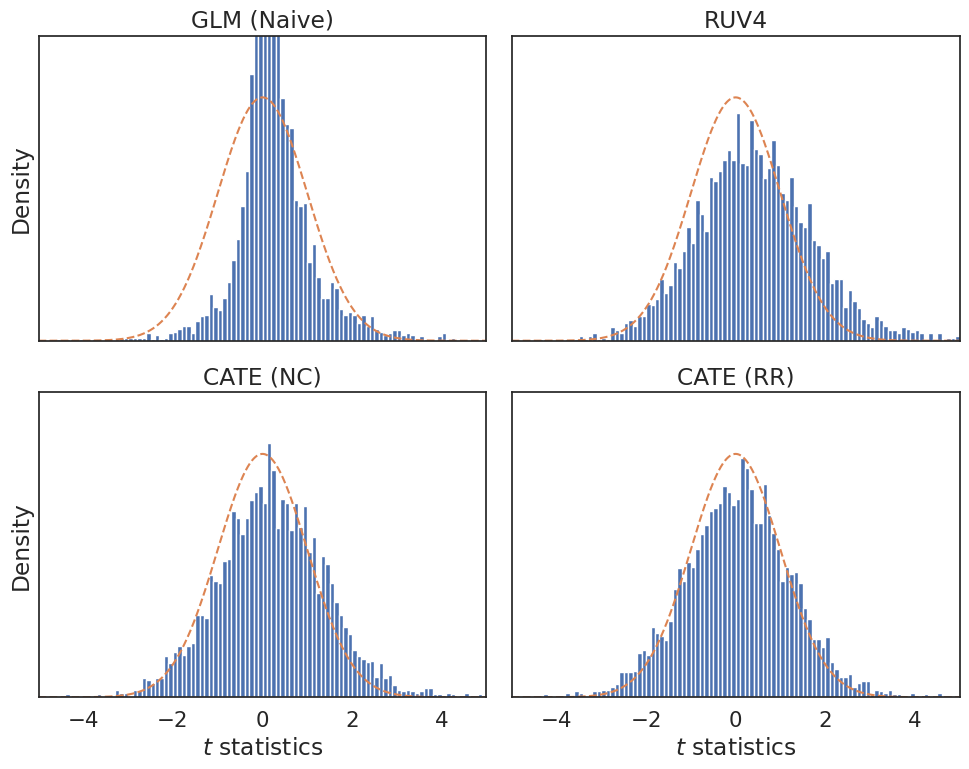

In [4]:
i_cov = -2
sns.set(font_scale=1.4, style='white')
fig, axes = plt.subplots(2,2, figsize=(10, 8), sharex=True, sharey=True)
xmax = 5
x_axis = np.arange(-xmax, xmax, 0.001)

method_names = ['GLM (Naive)', 'RUV4', 'CATE (NC)', 'CATE (RR)']
methods = ['GLM', 'RUV4_10', 'CATE_10', 'CATEs_10']
for i in range(2):
    for j in range(2):
        method = methods[i*2+j]

        try:
            if method.startswith('PII') or method=='GLM':
                with open('../results/LUHMES/output_{}.npz'.format(method), 'rb') as f:
                    t_values = np.load(f)['t_values']
                    t_values = np.r_[t_values[:1,:], t_values[-13:,:]]
            else:
                with h5py.File('../results/LUHMES/output_{}.h5'.format(method), 'r') as f:
                    t_values = np.array(f['t_values'], dtype='float')[:,CC]
            
            axes[i,j].hist(t_values[i_cov,:], bins=100, range=(-xmax,xmax), density=True)
            axes[i,j].plot(x_axis, sp.stats.norm.pdf(x_axis,0,1), '--')
            # axes[i,j].set_title(title_list[2*i+j])
            axes[i,j].set_ylim([0,0.5])
            if j>0:
                axes[i,j].set_yticks([])
            else:
                axes[i,j].set_ylabel('Density')
            axes[i,j].set_xlim(-xmax,xmax)
            if i>0:
                axes[i,j].set_xlabel('$t$ statistics')
            axes[i,j].set_title(method_names[i*2+j])
        except:
            continue

fig.tight_layout()
plt.savefig(path_result+'stat_other_methods.pdf', bbox_inches='tight', dpi=300)


# Figure 7: Histogram of PTEN perturbations (BII)

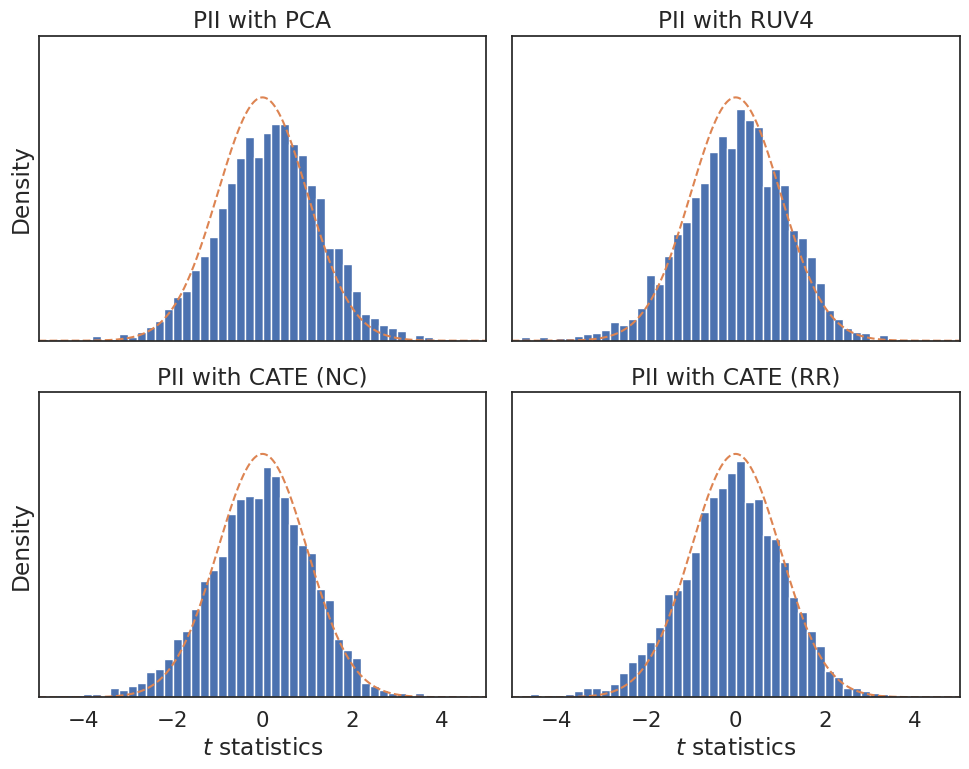

In [5]:
i_cov = -2
sns.set(font_scale=1.4, style='white')
fig, axes = plt.subplots(2,2, figsize=(10, 8), sharex=True, sharey=True)
xmax = 5
x_axis = np.arange(-xmax, xmax, 0.001)

method_names = ['PII with PCA', 'PII with RUV4', 'PII with CATE (NC)', 'PII with CATE (RR)'    ]
methods = ['PII_PCA_50', 'PII_RUV4_10', 'PII_CATE_10', 'PII_CATEs_10']
for i in range(2):
    for j in range(2):
        method = methods[i*2+j]

        try:
            if method.startswith('PII') or method=='GLM':
                with open('../results/LUHMES/output_{}.npz'.format(method), 'rb') as f:
                    t_values = np.load(f)['t_values']
                    t_values = np.r_[t_values[:1,:], t_values[-13:,:]]
            else:
                with h5py.File('../results/LUHMES/output_{}.h5'.format(method), 'r') as f:
                    t_values = np.array(f['t_values'], dtype='float')[:,CC]
            
            axes[i,j].hist(t_values[i_cov,:], bins=50, range=(-xmax,xmax), density=True)
            axes[i,j].plot(x_axis, sp.stats.norm.pdf(x_axis,0,1), '--')
            # axes[i,j].set_title(title_list[2*i+j])
            axes[i,j].set_ylim([0,0.5])
            if j>0:
                axes[i,j].set_yticks([])
            else:
                axes[i,j].set_ylabel('Density')
            axes[i,j].set_xlim(-xmax,xmax)
            if i>0:
                axes[i,j].set_xlabel('$t$ statistics')
            axes[i,j].set_title(method_names[i*2+j])
        except:
            print(method)
            continue

fig.tight_layout()
plt.savefig(path_result+'stat_PII.pdf', bbox_inches='tight', dpi=300)

# Figure F3: Histogram of pseudotime

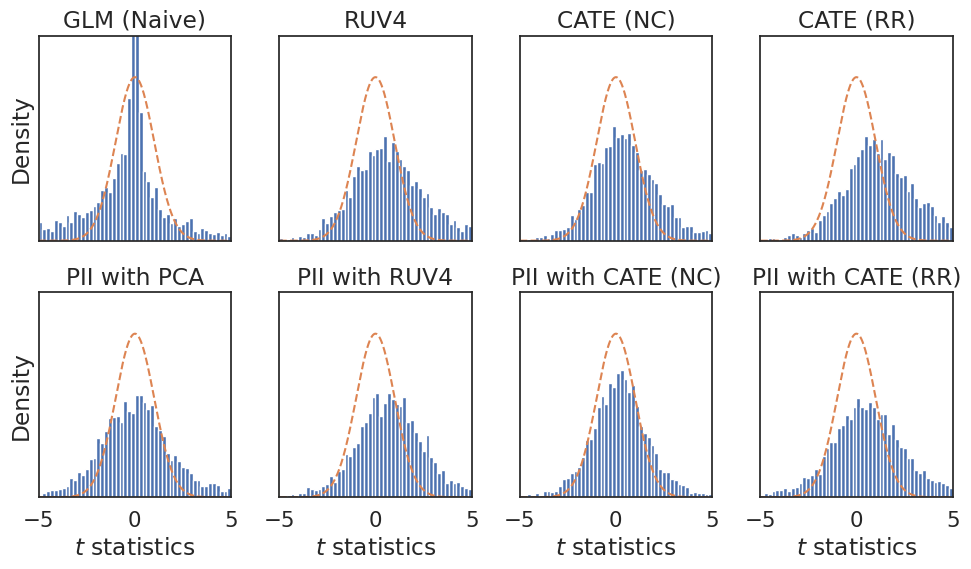

In [6]:
i_cov = 0
sns.set(font_scale=1.4, style='white')
fig, axes = plt.subplots(2,4, figsize=(10, 6), sharex=True, sharey=True)
xmax = 5
x_axis = np.arange(-xmax, xmax, 0.001)

method_names = ['GLM (Naive)', 'RUV4', 'CATE (NC)', 'CATE (RR)', 'PII with PCA', 'PII with RUV4', 'PII with CATE (NC)', 'PII with CATE (RR)']
methods = ['GLM', 'RUV4_10', 'CATE_10', 'CATEs_10', 'PII_PCA_50', 'PII_RUV4_10', 'PII_CATE_10', 'PII_CATEs_10']

for i in range(2):
    for j in range(4):
        method = methods[i*4+j]

        try:
            if method.startswith('PII') or method=='GLM':
                with open('../results/LUHMES/output_{}.npz'.format(method), 'rb') as f:
                    t_values = np.load(f)['t_values']
                    t_values = np.r_[t_values[:1,:], t_values[-13:,:]]
            else:
                with h5py.File('../results/LUHMES/output_{}.h5'.format(method), 'r') as f:
                    t_values = np.array(f['t_values'], dtype='float')[:,CC]
            
            axes[i,j].hist(t_values[i_cov,:], bins=50, range=(-xmax,xmax), density=True)
            axes[i,j].plot(x_axis, sp.stats.norm.pdf(x_axis,0,1), '--')
            axes[i,j].set_ylim([0,0.5])
            if j>0:
                axes[i,j].set_yticks([])
            else:
                axes[i,j].set_ylabel('Density')
            axes[i,j].set_xlim(-xmax,xmax)
            if i>0:
                axes[i,j].set_xlabel('$t$ statistics')
            axes[i,j].set_title(method_names[i*4+j])
        except:
            print(method)
            continue

fig.tight_layout()
plt.savefig(path_result+'stat_ps.pdf', bbox_inches='tight', dpi=300)

# Figures 8(a)-(b): Upset plot

In [7]:
j = -2
df = pd.DataFrame()
pvals = []; pvals_ps = []; hbetas = []
r = 10
methods = ['GLM', 'RUV4_{}'.format(r), 'CATE_{}'.format(r), 'CATEs_{}'.format(r)]
method_names = ['GLM (Naive)', 'RUV4', 'CATE (NC)', 'CATE (RR)']
methods = ['RUV4_{}'.format(r), 'CATE_{}'.format(r), 'CATEs_{}'.format(r)]
method_names = ['RUV4', 'CATE (NC)', 'CATE (RR)']
for method in methods:
    try:
        if method.startswith('PII') or method.startswith('GLM'):
            with open('results/LUHMES/output_{}.npz'.format(method), 'rb') as f:
                p_values = np.load(f)['p_values']
                p_values = np.r_[p_values[:1,:], p_values[-13:,:]]
                hbeta = np.load(f)['hbeta']
        else:
            with h5py.File('results/LUHMES/output_{}.h5'.format(method), 'r') as f:
                p_values = np.array(f['p_values'], dtype='float')[:,CC]
                hbeta = np.array(f['beta'], dtype='float')[:,CC]

        pvals.append(p_values[j,:])
        pvals_ps.append(p_values[0,:])
        hbetas.append(hbeta[j,:])
    except:
        print(method)
        continue

discoveries1 = pd.DataFrame(np.c_[pvals].T<0.05, columns = method_names)
discoveries = (discoveries1==1)
discoveries = discoveries.loc[np.any(discoveries, axis=1)]
methods = np.array(method_names)    

/home/jinhongd/anaconda3/envs/renv/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/jinhongd/anaconda3/envs/renv/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

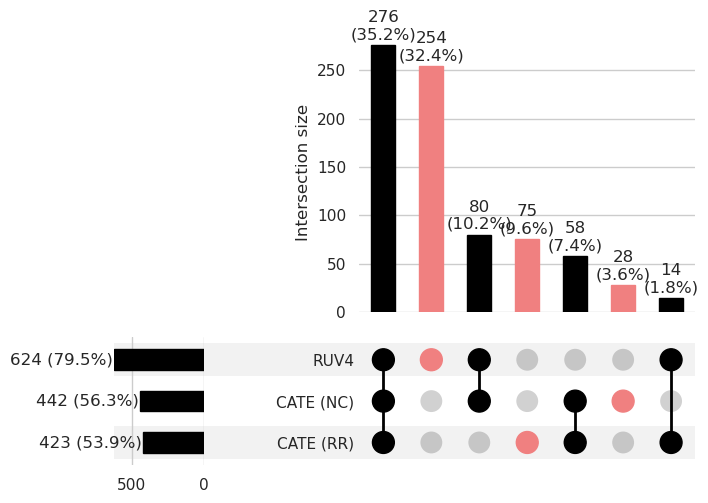

In [8]:
sns.set_theme(style="white", rc={"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom": False})

_df = discoveries.reset_index(drop=True)
fig2 = plt.figure(figsize=(8, 5))
upset = UpSet(from_indicators(_df).groupby(methods[::-1].tolist()).count(),
      sort_categories_by='input', sort_by='cardinality', show_percentages=True,
      element_size=45, show_counts=True)
upset.style_subsets(min_degree=1, facecolor="lightcoral")
upset.style_subsets(min_degree=2, facecolor="black")
upset.style_subsets(min_degree=3, facecolor="black")
upset.plot(fig=fig2)
plt.savefig(path_result+'upset_other_methods.pdf', bbox_inches='tight', dpi=300)

In [9]:
j = -2
df = pd.DataFrame()
pvals = []; pvals_ps = []; hbetas = []; hbetas_ps = []
# r = 10
methods = ['PII_PCA_50', 'PII_RUV4_{}'.format(r), 'PII_CATE_{}'.format(r), 'PII_CATEs_{}'.format(r)]
method_names = ['PII with PCA', 'PII with RUV4', 'PII with CATE (NC)', 'PII with CATE (RR)']
methods = ['PII_RUV4_{}'.format(r), 'PII_CATE_{}'.format(r), 'PII_CATEs_{}'.format(r)]
method_names = ['PII with RUV4', 'PII with CATE (NC)', 'PII with CATE (RR)']
for method in methods:
    try:
        if method.startswith('PII') or method.startswith('GLM'):
            with open('results/LUHMES/output_{}.npz'.format(method), 'rb') as f:
                p_values = np.load(f)['p_values']
                p_values = np.r_[p_values[:1,:], p_values[-13:,:]]
                hbeta = np.load(f)['hbeta']
        else:
            with h5py.File('results/LUHMES/output_{}.h5'.format(method), 'r') as f:
                p_values = np.array(f['p_values'], dtype='float')[:,CC]
                hbeta = np.load(f)['hbeta'][:,CC]

        pvals.append(p_values[j,:])
        pvals_ps.append(p_values[0,:])
        hbetas.append(hbeta[j,:])
        hbetas_ps.append(hbeta[0,:])
    except:
        print(method)
        continue
discoveries2 = pd.DataFrame(np.c_[pvals].T<0.05, columns = method_names)
# discoveries.fillna(0, inplace=True)
discoveries = (discoveries2==1)
discoveries = discoveries.loc[np.any(discoveries, axis=1)]
methods = np.array(method_names)    

/home/jinhongd/anaconda3/envs/renv/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/jinhongd/anaconda3/envs/renv/lib/python3.12/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

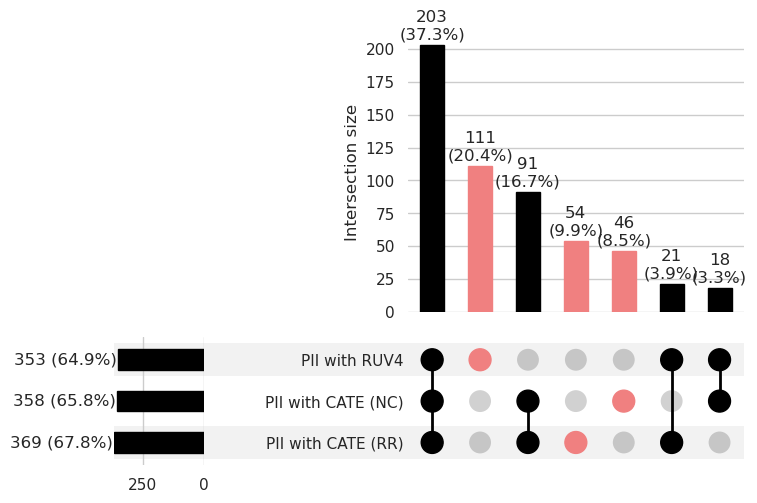

In [10]:
sns.set_theme(style="white", rc={"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False, "axes.spines.bottom": False})

_df = discoveries.reset_index(drop=True)
fig2 = plt.figure(figsize=(8, 5))
upset = UpSet(from_indicators(_df).groupby(methods[::-1].tolist()).count(),
      sort_categories_by='input', sort_by='cardinality', show_percentages=True,
      element_size=45, show_counts=True)
upset.style_subsets(min_degree=1, facecolor="lightcoral")
upset.style_subsets(min_degree=2, facecolor="black")
upset.style_subsets(min_degree=3, facecolor="black")
upset.plot(fig=fig2)
plt.savefig(path_result+'upset_PII.pdf', bbox_inches='tight', dpi=300)

# Figure 8(c): Venn

In [11]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from matplotlib_venn.layout.venn2 import DefaultLayoutAlgorithm


In [12]:
def layout_algorithm(*args,**kwargs):
    alg = DefaultLayoutAlgorithm(*args,**kwargs)
    def func(subsets, set_labels):
        layout = alg(subsets, set_labels)
        for point in layout.centers:
            point.x, point.y = point.y, point.x
        for label in layout.set_labels_layout:
            label.position.x, label.position.y = label.position.y, label.position.x
            label.kwargs['ha'] = 'right'
        return layout
    
    return func


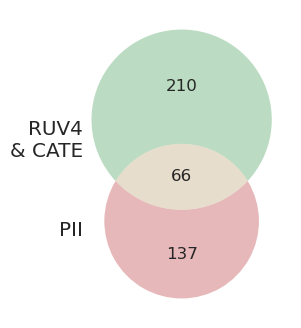

In [13]:
sets = [
set(np.where(discoveries2.iloc[:,-3:].sum(axis=1)==3)[0]),
set(np.where(discoveries1.iloc[:,-3:].sum(axis=1)==3)[0])
]

# Create a Venn diagram using matplotlib_venn
fig, ax = plt.subplots(figsize=(8, 4))
venn = venn2(sets, ['PII  ', 'RUV4\n& CATE'], ax=ax, layout_algorithm=layout_algorithm())
plt.savefig(path_result+'venn.pdf', bbox_inches='tight', dpi=300)

# Figure F5: Violinplot

In [14]:
from statsmodels.stats.multitest import multipletests
with open('results/LUHMES/output_{}.npz'.format('PII_PCA_20'), 'rb') as f:
    p_values = np.load(f)['p_values']
    t_values = np.load(f)['t_values']
    hbeta = np.load(f)['hbeta']
    var_beta = np.load(f)['var_beta']
    Y_U_pred = np.load(f)['Y_U_pred']
    p_values = np.r_[p_values[:1,:], p_values[-13:,:]]

qvals = np.array([multipletests(p_values[j,:], alpha=0.05, method='fdr_bh')[1] for j in range(p_values.shape[0])])


In [15]:
from statsmodels.stats.multitest import multipletests
pvals = np.array(pvals)
qval_pten = np.array([multipletests(pvals[j,:], alpha=0.05, method='fdr_bh')[1] for j in range(pvals.shape[0])])

pvals_ps = np.array(pvals_ps)
qval_ps = np.array([multipletests(pvals_ps[j,:], alpha=0.05, method='fdr_bh')[1] for j in range(pvals_ps.shape[0])])

hbetas = np.array(hbetas)

4


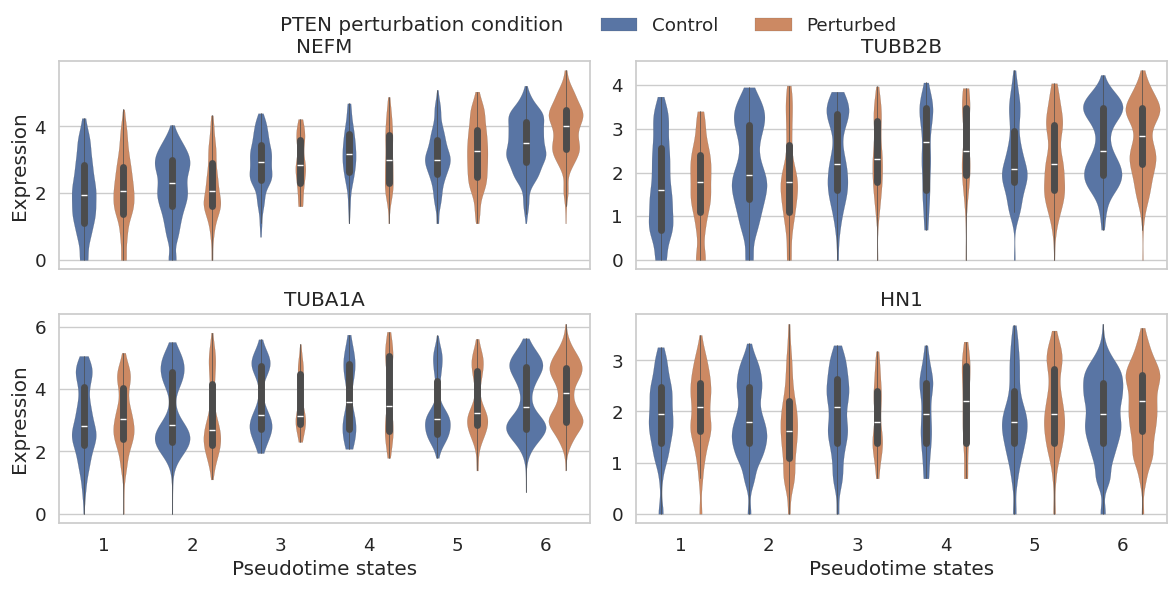

In [16]:
sns.set(style='whitegrid', font_scale=1.2)
i_cells = (X[:,-2]>0)|(np.sum(perturbed_one_hot_encoded, axis=1)==0)
idx = (np.sum(pvals_ps[-3:,:]<0.01, axis=0)==3) & (np.sum(pvals[-3:,:]<0.01, axis=0)==3) \
    & (np.median(Y[:,CC], axis=0) > 1) & (np.mean(hbetas[-3:,:], axis=0) > 0)
print(np.sum(idx))
i_genes = np.argsort(
    np.where(idx, np.abs(np.mean(hbetas[-3:,:], axis=0)), 0)
    )[-4:][::-1]
fig, axes = plt.subplots(2,2, figsize=(12,6), sharex=True)

for i in range(2):
    for j in range(2):
        i_gene = i_genes[i*2+j]
        _df = pd.DataFrame({
            'pt': pt_state[i_cells], 
            'exp': np.log1p(Y[i_cells][:,CC[i_gene]]),
            'peturb': np.where(X[i_cells,:][:,-2]<0, 0, 1)
        })
        # Repeat rows by 'pt' by 2 times, except when 'pt' == 6. For better visualization.
        _df = pd.concat([_df, _df, 
            _df.loc[_df['pt'] != 6], _df.loc[_df['pt'] != 6]], axis=0).reset_index(drop=True)
    
        sns.violinplot(_df, x='pt', y='exp', hue='peturb', linewidth=.1, 
            width=0.9, density_norm='count', common_norm=True, split=False, cut=0, fill=True, ax=axes[i,j],
            inner_kws=dict(box_width=5, whis_width=0.5))
        axes[i,j].set_title(f'{gene_names[CC[i_gene]]}')
        if j>0:
            axes[i,j].set_ylabel('')
        else:
            axes[i,j].set_ylabel('Expression')

        if i==1:
            axes[i,j].set_xlabel('Pseudotime states')
            axes[i,j].set_xticks(np.arange(6))
            axes[i,j].set_xticklabels(np.arange(6)+1)
        else:
            axes[i,j].set_xlabel('')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0,0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
for i in range(2):
    for j in range(2):
        axes[i,j].get_legend().remove()
labels = ['Control', 'Perturbed']
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=10, title='PTEN perturbation condition', frameon=False)           
legend_title_left(legend)

fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig('results/LUHMES/PTEN_perturbation.pdf', dpi=300, bbox_inches='tight')
